# Análisis Exploratorio

    Fuente de información: RNMC
    Archivos: 
    verify_enrich_rnmc_12022020.csv

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import calendar
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', None)  
from wordcloud import WordCloud, STOPWORDS
import folium
from folium import plugins
import geopandas as gpd

# Methods to visualize analysis results

In [2]:
def print_Data(df):
    if len(df)>10:
        topdata=(df.sort_values(by=['Frecuencia'],ascending=False)[:5])
        taildata = (df.sort_values(by=['Frecuencia'],ascending=True)[:5])
        print("Top values")
        display(topdata.style.hide_index())
        print("Bottom values")
        display(taildata.style.hide_index())
    else:
        display(df.style.hide_index())

In [3]:
def basic_Description(df):
    print_Data(df)
    print("Statistics")
    display(pd.DataFrame(df.describe()))
    sns.boxplot(y=df['Frecuencia'])

In [4]:
def create_Subdata(df,variables_array):
    subdata=pd.DataFrame(df.groupby(variables_array).size(),columns=["Frecuencia"]).sort_index().reset_index()
    return subdata

In [52]:
def normalize_subdata(subdata, years_array):
    subdata['Factor normalizacion']= subdata.apply (lambda row: norm_factor_localidad(row['COD_LOCALIDAD'],years_array), axis=1)
    subdata['Frecuencia']= subdata['Frecuencia']*subdata['Factor normalizacion']
    subdata.drop(columns=['Factor normalizacion'],inplace=True)
    #subdata.drop([0, 19], inplace=True) #drop sin localización
    return subdata


def norm_factor_localidad(cod_localidad,years_array):
    num_inhabitants = 10000
    if cod_localidad != 99:
        population_values =[]
        for year in years_array:
            value = poblacion_localidades.at[cod_localidad,year]
            population_values.append(int(value.strip().replace(',','')))
        
        mean_population = int(sum(population_values)/len(population_values))
        norm_factor = num_inhabitants / mean_population
        
        return norm_factor
    else:
        return 1

In [6]:
def bar_figure_top_values(df,variable,fig_name):
    if len(df)>22:
        topdata=(df.sort_values(by=['Frecuencia'],ascending=False)[:10])
    else:
        topdata=df.sort_values(by=['Frecuencia'],ascending=False)
        
    fig = px.bar(topdata, x='Frecuencia', y=variable, orientation='h', color = variable, 
             color_discrete_sequence = px.colors.qualitative.Prism[2:])
    fig.update_layout(yaxis={"type":"category"}, showlegend=False)
    file_path = "figuras_rnmc/"+fig_name
    if fig_name != '':
        fig.write_image(file_path)
    fig.show()

In [7]:
def line_figure(df,x_var,min_values,max_values,fig_name):
    fig = px.line(df, x=x_var, y='Frecuencia', color_discrete_sequence = px.colors.qualitative.Prism[1:])
    fig.update_xaxes(title=x_var)
    fig.update_yaxes(title='Frecuencia')
    fig.update_layout(
        annotations=[
            go.layout.Annotation(
              x=i[0],
              y=i[1],
              xref="x",
              yref="y",
              showarrow=False,
              text=str(i[0])+" : "+str(i[1]),
              font=dict(
                  family="Courier New, monospace",
                  size=16,
                  color="black"
              ),
          ) for i in df.sort_values('Frecuencia').head(min_values).append(df.sort_values('Frecuencia').tail(max_values))[[x_var,'Frecuencia']].values
        ]
    )
    file_path = "figuras_rnmc/"+fig_name
    if fig_name != '':
        fig.write_image(file_path,width=1000,height=500)
    fig.show()
    print("Promedio: ",df.mean())
    print("Desviación estandar: ",df.std())

In [8]:
def bar_figure_probabilities(df,variable,values_order,media_factor,fig_name):
    df['Porcentaje']=df['Frecuencia']/df['Frecuencia'].sum()*100
    fig=px.bar(df,x='Porcentaje',color=variable,y=variable,orientation='h',
               category_orders={variable: values_order},
               color_discrete_sequence = px.colors.qualitative.Prism[1:])
    fig.update(layout_showlegend=False)

    fig.add_trace(go.Scatter(
        x=[df.Porcentaje.mean()]*2,
        y=[values_order[0],values_order[-1]],
        text=['Media='+str(round(df.Frecuencia.mean()/media_factor,2)),
              ''
              ],
        line=dict(color='black', width=2),
        mode="text+lines",
    ))
    fig.add_trace(go.Scatter(
        x=[df.Porcentaje.mean()+df.Porcentaje.std()]*2,
        y=[values_order[0],values_order[-1]],
        text=['',
              'std='+str(round(df.Frecuencia.std()/media_factor,2)),
              ],
        line=dict(color='black', width=2,
                                  dash='dash'),
        mode="text+lines",
    ))
    fig.add_trace(go.Scatter(
        x=[df.Porcentaje.mean()-df.Porcentaje.std()]*2,
        y=[values_order[0],values_order[-1]],
        text=['',
              'std='+str(round(df.Frecuencia.std()/media_factor,2)),
              ],
        line=dict(color='black', width=2,
                                  dash='dash'),
        mode="text+lines",
    ))
    file_path = "figuras_rnmc/"+fig_name
    if fig_name != '':
        fig.write_image(file_path,width=1000,height=500)
    fig.show()

In [9]:
def bubbles_figure_probabilities(df,var1,var2,var1_order,var2_order,fig_name):
    df['Porcentaje']=df['Frecuencia']/df['Frecuencia'].sum()*100
    fig = px.scatter(df, x=var1, y="Porcentaje", size="Porcentaje", color=var2,
                     width=1000, height=600, color_discrete_sequence = px.colors.qualitative.Prism[1:],
                     category_orders={var2: var2_order}, hover_name=var2, size_max=40)
    fig.update_xaxes(tickangle=0,categoryorder="array", categoryarray=var1_order)
    if len(df[var1].unique()) > 10:
        fig.update_xaxes(tickangle=90)
    file_path = "figuras_rnmc/"+fig_name
    if fig_name != '':
        fig.write_image(file_path,width=1000,height=500)
    fig.show()

In [10]:
def table_figure_probabilities(df,var1,var2,var1_order,var2_order,var_aux,fig_name):
    A=df.groupby([var1,var2]).agg({var_aux:'count'}).reset_index().rename(columns={var_aux:'Frecuencia'})
    A['Porcentaje']=A['Frecuencia']/A['Frecuencia'].sum()
    join=(A.pivot(var1,var2,'Porcentaje')).fillna(0)
    if len(var2_order) > 0:
        join = join.reindex(var2_order, axis=1)
    if len(var1_order) > 0:
        join = join.reindex(var1_order)
    gc=join/join.sum(axis=0)
    gf=(join.T/join.sum(axis=1)).T
    M=[join,gc,gf]
    title=["join",'g_columna',"g_fila"]

    for k in range(3):
     print(title[k])
     fig, ax = plt.subplots(1,1,sharex=True, sharey=True)
     fig.set_size_inches(7, 6)
     g=sns.heatmap(M[k],vmin=0, vmax=0.4,annot=True,fmt=".1%",linewidths=0,cmap="Blues",cbar=False)
     g.set_yticklabels(g.get_yticklabels(), rotation = 0)
     bottom, top = ax.get_ylim()
     ax.set_ylim(bottom + 0.5, top - 0.5)
     if k == 1:
       ax.vlines(np.arange(20), *ax.get_ylim())
     if k == 2:
       ax.hlines(np.arange(20), *ax.get_xlim())
     
     file_path = "figuras_rnmc/"+fig_name
     plt.savefig(file_path+title[k],dpi=300,bbox_inches = "tight")
     plt.show()

In [63]:
def map_localidad(ax,df,col_localidad,col_vals,vmin=None,vmax=None):
  loc_geo="/Users/anamaria/Desktop/dev/security_project/assets/localidades_polygon.json"
  loc_=gpd.read_file(loc_geo)
  loc_=loc_.merge(df,left_on='LocNombre',right_on=col_localidad)
  loc_.plot(cmap='viridis',column=col_vals,legend=True,ax=ax,vmin=vmin,vmax=vmax)  

# Load datasets

In [12]:
data_location = '/Users/anamaria/Desktop/dev/security_project/datasets/06. verify_enrich_rnmc_12022020.csv'
data=pd.read_csv(data_location,delimiter=",")

/Users/anamaria/Desktop/dev/security_project/security_venv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning:

Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.



## Assets

In [13]:
data_location = '/Users/anamaria/Desktop/dev/security_project/assets/poblacion_localidades.csv'
poblacion_localidades=pd.read_csv(data_location,delimiter=",")

In [14]:
poblacion_localidades['Cod Localidad'].astype(int)
poblacion_localidades.set_index('Cod Localidad', inplace=True)

# Basic dataset description

In [15]:
data.head()

,EXPEDIENTE,COMPARENDO,FECHA,HORA,ANIO,MES,LATITUD,LONGITUD,COD_LOCALIDAD,NOMBRE_LOCALIDAD,COD_UPZ,NOMBRE_UPZ,COD_SCAT,NOMBRE_SECTOR_CAT,COD_BARRIO,NOMBRE_BARRIO,TIPO_SITIO,RANGO_EDAD_1,TITULO,CAPITULO,ARTICULO,DESCRIPCION_ARTICULO,COD_COMPORTAMIENTO,DESCRIPCION_COMPORTAMIENTO,TIPO_PRIORIZACION,MEDIDA_CORRECTIVA_CODIGO,ES_PEDAGOGICO,STR_RELATO_HECHOS,ACTIVIDAD_COMERCIAL,RAZON_SOCIAL,NUM_ID_HECHOS
0,11-001-6-2017-61,111056601,2017-01-30,0,2017,1,4.580549,-74.142739,6,TUNJUELITO,UPZ42,VENECIA,2413,MUZU,2950,VILLA XIMENA,SITIOS PUBLICOS O ABIERTOS AL PUBLICO,30 - 34 A?OS,Titulo 3,Capitulo 1,27,"Comportamientos que ponen en riesgo la vida e integridad. Corregido por el art. 1, Decreto 555 de 2017. Los siguientes comportamientos ponen en riesgo la vida e integridad de las personas, y, por lo tanto, son contrarios a la convivencia:",Numeral 6,"Portar armas, elementos cortantes, punzantes o semejantes, o sustancias peligrosas, en areas comunes o lugares abiertos al publico. Se exceptua a quien demuestre que tales elementos o sustancias constituyen una herramienta de su actividad deportiva, oficio, profesion o estudio.",RI?AS,"MULTA GENERAL TIPO 2; PROHIBICION DE INGRESO A EVENTOS QUE INVOLUCREN AGLOMERACIONES DE PUBLICO COMPLEJAS O NO COMPLEJAS, DESTRUCCION DE BIEN;",SI,MEDIANTE REGISTRO A PERSONA SE HAYA ARMA CORTOPUNZANTE EN LA PRETINA DEL PANTALON,ND,ND,303
1,11-001-6-2017-127,11001064701,2017-01-30,0,2017,1,4.596728,-74.074857,17,CANDELARIA,UPZ94,LA CANDELARIA,3106,CENTRO ADMINISTRATIVO,186,CENTRO ADMINISTRATIVO,SITIOS PUBLICOS O ABIERTOS AL PUBLICO,30 - 34 A?OS,Titulo 3,Capitulo 1,27,"Comportamientos que ponen en riesgo la vida e integridad. Corregido por el art. 1, Decreto 555 de 2017. Los siguientes comportamientos ponen en riesgo la vida e integridad de las personas, y, por lo tanto, son contrarios a la convivencia:",Numeral 6,"Portar armas, elementos cortantes, punzantes o semejantes, o sustancias peligrosas, en areas comunes o lugares abiertos al publico. Se exceptua a quien demuestre que tales elementos o sustancias constituyen una herramienta de su actividad deportiva, oficio, profesion o estudio.",RI?AS,"MULTA GENERAL TIPO 2; PROHIBICION DE INGRESO A EVENTOS QUE INVOLUCREN AGLOMERACIONES DE PUBLICO COMPLEJAS O NO COMPLEJAS, DESTRUCCION DE BIEN;",SI,EL CIUDADANO SE ENCONTRABA REALIZANDO O PORTANDO ARMAS CORTOPULSANTES EN LA DIRECCION ANTES MENCIONADA EN EL ESPACIO PUBLICO LO CUAL ES UN COMPORTAMIENTO CONTRARIO A LA CONVIVEVNCIA,ND,ND,511
2,11-001-6-2017-146,11001040453,2017-01-30,0,2017,1,4.588841,-74.071710,3,SANTA FE,UPZ96,LOURDES,3212,LOURDES,3458,LOURDES,SITIOS PUBLICOS O ABIERTOS AL PUBLICO,25 - 29 A?OS,Titulo 3,Capitulo 1,27,"Comportamientos que ponen en riesgo la vida e integridad. Corregido por el art. 1, Decreto 555 de 2017. Los siguientes comportamientos ponen en riesgo la vida e integridad de las personas, y, por lo tanto, son contrarios a la convivencia:",Numeral 3,Agredir fisicamente a personas por cualquier medio.,RI?AS,MULTA GENERAL TIPO 3;,SI,AGREDIR FISICAMENTE AL SE?OR ANDRES GONZALES CASA,ND,ND,597
3,11-001-6-2017-157,111064578,2017-01-30,0,2017,1,4.603355,-74.081888,14,LOS MARTIRES,UPZ102,LA SABANA,4103,VOTO NACIONAL,2676,VOTO NACIONAL,SITIOS PUBLICOS O ABIERTOS AL PUBLICO,30 - 34 A?OS,Titulo 3,Capitulo 1,27,"Comportamientos que ponen en riesgo la vida e integridad. Corregido por el art. 1, Decreto 555 de 2017. Los siguientes comportamientos ponen en riesgo la vida e integridad de las personas, y, por lo tanto, son contrarios a la convivencia:",Numeral 1,"Re?ir, incitar o incurrir en confrontaciones violentas que puedan derivar en agresiones fisicas.",RI?AS,MULTA GENERAL TIPO 2;,SI,POR ENCONTRARSE EN ALTO GRADO DE EXALTACION Y FOMENTANDO RI?A,ND,ND,637
4,11-001-6-2017-163,11001111037326,2017-01-30,0,2017,1,4.621319,-74.153640,8,KENNEDY,UPZ47,KENNEDY CENTRAL,4511,CIUDAD KENNEDY CENTRAL,1026,CIUDAD KENNEDY SUPERMANZANA 8,SITIOS PUBLICOS O ABIERTOS AL PUBLICO,20 - 24 A?OS,Titulo 3,Capitulo 1,27,"Comportam

In [16]:
print("Tamaño:",data.shape)
print("size: ",data.size)
print("Porcentaje Celdas Vacias:",data.isna().mean().mean())
print("Porcentaje Celdas con valor '-':",(data == "-").mean().mean())
print("Filas duplicadas",data.duplicated().sum())

Tamaño: (231117, 31)
size:  7164627
Porcentaje Celdas Vacias: 0.0


/Users/anamaria/Desktop/dev/security_project/security_venv/lib/python3.7/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



Porcentaje Celdas con valor '-': 0.0
Filas duplicadas 0


In [17]:
pd.DataFrame({"Tipo de dato":data.dtypes.values,
              "Celdas con valor '-'":(data == '-').sum().values,
              "Celdas vacías": data.isna().sum().values},
             index=data.columns)

,Tipo de dato,Celdas con valor '-',Celdas vacías
EXPEDIENTE,object,0,0
COMPARENDO,object,0,0
FECHA,object,0,0
HORA,int64,0,0
ANIO,int64,0,0
MES,int64,0,0
LATITUD,float64,0,0
LONGITUD,float64,0,0
COD_LOCALIDAD,int64,0,0
NOMBRE_LOCALIDAD,object,0,0


# Create aditional variables or convert to another format

In [18]:
# Fecha to datetime
data['FECHA'] =  pd.to_datetime(data['FECHA'])

#Day of week
data['day_of_week'] = data["FECHA"].dt.day_name()
weeks_between = round((data["FECHA"].max()-data["FECHA"].min())/np.timedelta64(1,'W'))

#Format 'HORA' field into datetime to proper visualization
data['time_stamp']=pd.to_datetime(data["HORA"].astype(str).str.rjust(4,'0'),format= '%H%M').dt.time

In [19]:
#DIA_EXTENDIDO for all dataset
data['DIA_EXTENDIDO'] = data['day_of_week']
data.loc[(data.HORA >= 0) & (data.HORA <= 359) & (data.day_of_week == 'Monday'), 'DIA_EXTENDIDO'] = 'Sunday'
data.loc[(data.HORA >= 0) & (data.HORA <= 359) & (data.day_of_week == 'Tuesday'), 'DIA_EXTENDIDO'] = 'Monday'
data.loc[(data.HORA >= 0) & (data.HORA <= 359) & (data.day_of_week == 'Wednesday'), 'DIA_EXTENDIDO'] = 'Tuesday'
data.loc[(data.HORA >= 0) & (data.HORA <= 359) & (data.day_of_week == 'Thursday'), 'DIA_EXTENDIDO'] = 'Wednesday'
data.loc[(data.HORA >= 0) & (data.HORA <= 359) & (data.day_of_week == 'Friday'), 'DIA_EXTENDIDO'] = 'Thursday'
data.loc[(data.HORA >= 0) & (data.HORA <= 359) & (data.day_of_week == 'Saturday'), 'DIA_EXTENDIDO'] = 'Friday'
data.loc[(data.HORA >= 0) & (data.HORA <= 359) & (data.day_of_week == 'Sunday'), 'DIA_EXTENDIDO'] = 'Saturday'

In [20]:
#RANGO_HORA each 4 hours
data.loc[(data.HORA >= 0) & (data.HORA <= 359), 'RANGO_HORA'] = '0:00 a 3:59'
data.loc[(data.HORA >= 400) & (data.HORA <= 759), 'RANGO_HORA'] = '4:00 a 7:59'
data.loc[(data.HORA >= 800) & (data.HORA <= 1159), 'RANGO_HORA'] = '8:00 a 11:59'
data.loc[(data.HORA >= 1200) & (data.HORA <= 1559), 'RANGO_HORA'] = '12:00 a 15:59'
data.loc[(data.HORA >= 1600) & (data.HORA <= 1959), 'RANGO_HORA'] = '16:00 a 19:59'
data.loc[(data.HORA >= 2000) & (data.HORA <= 2359), 'RANGO_HORA'] = '20:00 a 23:59'

In [66]:
data = data.loc[data['NOMBRE_LOCALIDAD'] != 'SUMAPAZ']

# Análisis univariado

### Analisis campo 'FECHA'

Top values


FECHA,Frecuencia
2019-03-17 00:00:00,541
2018-08-18 00:00:00,537
2018-08-19 00:00:00,535
2019-03-24 00:00:00,533
2019-01-23 00:00:00,531


Bottom values


FECHA,Frecuencia
2017-04-16 00:00:00,7
2017-04-11 00:00:00,7
2017-04-17 00:00:00,9
2017-04-15 00:00:00,11
2017-04-14 00:00:00,11


Statistics


,Frecuencia
count,1005.000000
mean,229.964179
std,144.737476
min,7.000000
25%,88.000000
50%,234.000000
75%,350.000000
max,541.000000


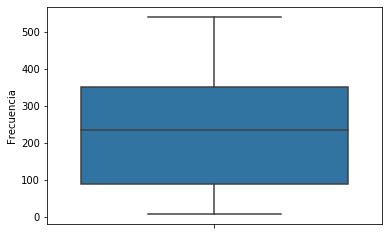

In [67]:
subdata = create_Subdata(data,["FECHA"])
basic_Description(subdata)

In [68]:
bar_figure_top_values(subdata,variable='FECHA',fig_name="riñas_rnmc_fecha_frecuencias.png")

In [69]:
line_figure(subdata,x_var='FECHA',min_values=1,max_values=1,fig_name="riñas_rnmc_fecha_serie_tiempo.png")

Promedio:  Frecuencia    229.964179
dtype: float64
Desviación estandar:  Frecuencia    144.737476
dtype: float64


### Analisis variable aux 'day_of_week'

day_of_week,Frecuencia
Friday,33364
Monday,30758
Saturday,35631
Sunday,35731
Thursday,32800
Tuesday,30726
Wednesday,32104


Statistics


,Frecuencia
count,7.000000
mean,33016.285714
std,2063.638269
min,30726.000000
25%,31431.000000
50%,32800.000000
75%,34497.500000
max,35731.000000


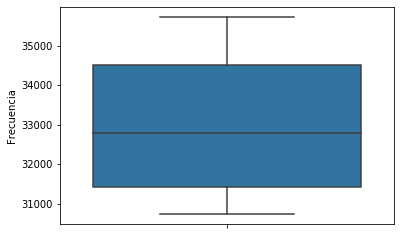

In [70]:
subdata = create_Subdata(data,["day_of_week"])
basic_Description(subdata)

In [71]:
values_order = ["Monday", "Tuesday", "Wednesday", "Thursday","Friday","Saturday","Sunday"]
media_factor = weeks_between
bar_figure_probabilities(subdata,'day_of_week',values_order,media_factor,fig_name="riñas_rnmc_dia_probabilidad.png")

### Analisis variable aux 'DIA_EXTENDIDO'

DIA_EXTENDIDO,Frecuencia
Friday,34790
Monday,30354
Saturday,37102
Sunday,32617
Thursday,32948
Tuesday,31014
Wednesday,32289


Statistics


,Frecuencia
count,7.000000
mean,33016.285714
std,2295.977404
min,30354.000000
25%,31651.500000
50%,32617.000000
75%,33869.000000
max,37102.000000


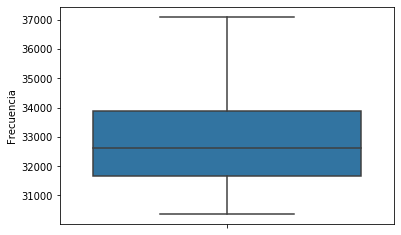

In [72]:
subdata = create_Subdata(data,["DIA_EXTENDIDO"])
basic_Description(subdata)

In [73]:
values_order = ["Monday", "Tuesday", "Wednesday", "Thursday","Friday","Saturday","Sunday"]
media_factor = weeks_between
bar_figure_probabilities(subdata,'DIA_EXTENDIDO',values_order,media_factor,fig_name="riñas_rnmc_dia_extendido_probabilidad.png")

### Análisis campo 'HORA'

Top values


HORA,Frecuencia
0,7996
1630,2256
1730,2142
1700,2138
1600,2094


Bottom values


HORA,Frecuencia
456,4
514,4
453,5
454,5
452,6


Statistics


,HORA,Frecuencia
count,1440.00000,1440.000000
mean,1179.50000,160.495833
std,692.67581,334.533476
min,0.00000,4.000000
25%,589.75000,40.000000
50%,1179.50000,68.000000
75%,1769.25000,115.000000
max,2359.00000,7996.000000


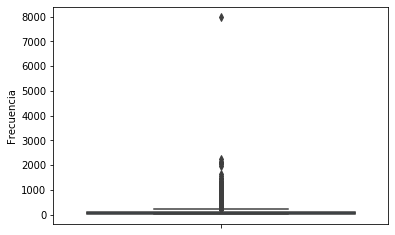

In [74]:
subdata = create_Subdata(data,["HORA"])
basic_Description(subdata)

In [75]:
bar_figure_top_values(subdata,variable='HORA',fig_name="riñas_rnmc_hora_frecuencias.png")

### Análisis campo 'time_stamp'

In [76]:
subdata = create_Subdata(data,["time_stamp"])
line_figure(subdata,x_var='time_stamp',min_values=1,max_values=1,fig_name="riñas_rnmc_hora_serie_tiempo.png")

Promedio:  Frecuencia    160.495833
dtype: float64
Desviación estandar:  Frecuencia    334.533476
dtype: float64


### Análisis campo 'ANIO'

ANIO,Frecuencia
2017,21767
2018,111190
2019,98157


Statistics


,ANIO,Frecuencia
count,3.0,3.000000
mean,2018.0,77038.000000
std,1.0,48307.632451
min,2017.0,21767.000000
25%,2017.5,59962.000000
50%,2018.0,98157.000000
75%,2018.5,104673.500000
max,2019.0,111190.000000


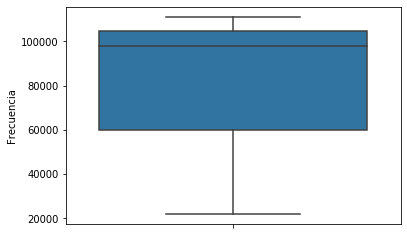

In [77]:
subdata = create_Subdata(data,["ANIO"])
basic_Description(subdata)

In [78]:
subdata['ANIO']=subdata["ANIO"].astype(str)
bar_figure_top_values(subdata,variable='ANIO',fig_name="riñas_rnmc_año_frecuencias.png")

### Análisis campo 'MES'

Top values


MES,Frecuencia
9,25355
10,23032
8,22792
5,19833
3,19677


Bottom values


MES,Frecuencia
12,12858
11,14022
4,17782
2,18250
1,18798


Statistics


,MES,Frecuencia
count,12.000000,12.000000
mean,6.500000,19259.500000
std,3.605551,3519.118911
min,1.000000,12858.000000
25%,3.750000,18133.000000
50%,6.500000,19357.500000
75%,9.250000,20572.750000
max,12.000000,25355.000000


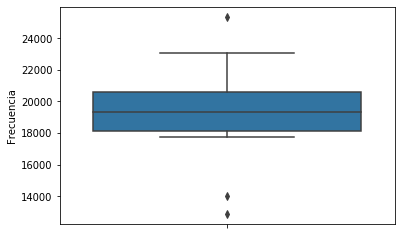

In [79]:
subdata = create_Subdata(data,["MES"])
basic_Description(subdata)

In [80]:
subdata['MES']=subdata["MES"].astype(str)
bar_figure_top_values(subdata,variable='MES',fig_name="riñas_rnmc_mes_frecuencias.png")

In [81]:
values_order = ["1","2","3","4","5","6","7","8","9","10","11","12"]
media_factor = 3
bar_figure_probabilities(subdata,'MES',values_order,media_factor,fig_name="riñas_rnmc_mes_probabilidad.png")

### Análisis campo 'COD_LOCALIDAD' y 'LOCALIDAD'

Top values


COD_LOCALIDAD,NOMBRE_LOCALIDAD,Frecuencia
7,BOSA,30946
8,KENNEDY,23791
19,CIUDAD BOLIVAR,22020
3,SANTA FE,19587
18,RAFAEL URIBE URIBE,18832


Bottom values


COD_LOCALIDAD,NOMBRE_LOCALIDAD,Frecuencia
2,CHAPINERO,2985
13,TEUSAQUILLO,3726
15,ANTONIO NARIÑO,4182
16,PUENTE ARANDA,4274
17,CANDELARIA,4406


Statistics


,COD_LOCALIDAD,Frecuencia
count,19.000000,19.000000
mean,10.000000,12163.894737
std,5.627314,8128.319649
min,1.000000,2985.000000
25%,5.500000,4773.000000
50%,10.000000,9806.000000
75%,14.500000,17442.500000
max,19.000000,30946.000000


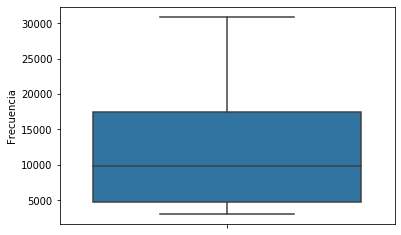

In [82]:
subdata = create_Subdata(data,["COD_LOCALIDAD","NOMBRE_LOCALIDAD"])
basic_Description(subdata)

In [83]:
bar_figure_top_values(subdata,variable='NOMBRE_LOCALIDAD',fig_name="riñas_rnmc_localidad_frecuencias.png")

In [84]:
values_order = []
media_factor = 1
bar_figure_probabilities(subdata,'NOMBRE_LOCALIDAD',values_order,media_factor,fig_name="riñas_rnmc_localidad_probabilidad.png")

### Análisis campo 'LOCALIDAD' normalizado por tamaño población

Top values


COD_LOCALIDAD,NOMBRE_LOCALIDAD,Frecuencia
7,BOSA,30946
8,KENNEDY,23791
19,CIUDAD BOLIVAR,22020
3,SANTA FE,19587
18,RAFAEL URIBE URIBE,18832


Bottom values


COD_LOCALIDAD,NOMBRE_LOCALIDAD,Frecuencia
2,CHAPINERO,2985
13,TEUSAQUILLO,3726
15,ANTONIO NARIÑO,4182
16,PUENTE ARANDA,4274
17,CANDELARIA,4406


Statistics


,COD_LOCALIDAD,Frecuencia
count,19.000000,19.000000
mean,10.000000,12163.894737
std,5.627314,8128.319649
min,1.000000,2985.000000
25%,5.500000,4773.000000
50%,10.000000,9806.000000
75%,14.500000,17442.500000
max,19.000000,30946.000000


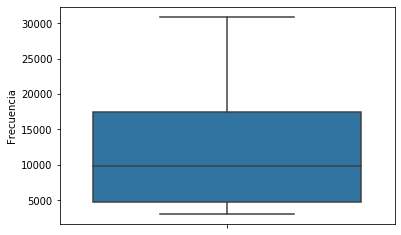

In [85]:
subdata = create_Subdata(data,["COD_LOCALIDAD","NOMBRE_LOCALIDAD"])
basic_Description(subdata)

In [87]:
years_array = ['2017','2018','2019']
normalize_subdata(subdata,years_array)

,COD_LOCALIDAD,NOMBRE_LOCALIDAD,Frecuencia
0,1,USAQUEN,108.161569
1,2,CHAPINERO,236.572434
2,3,SANTA FE,2087.076048
3,4,SAN CRISTOBAL,378.454462
4,5,USME,436.441049
5,6,TUNJUELITO,746.438441
6,7,BOSA,410.623180
7,8,KENNEDY,193.342441
8,9,FONTIBON,162.024373
9,10,ENGATIVA,111.026445


In [88]:
bar_figure_top_values(subdata,variable='NOMBRE_LOCALIDAD',fig_name="riñas_rnmc_localidad_normalizada_frecuencias.png")

In [89]:
values_order = []
media_factor = 1
bar_figure_probabilities(subdata,'NOMBRE_LOCALIDAD',values_order,media_factor,fig_name="riñas_rnmc_localidad_normalizada_probabilidad.png")

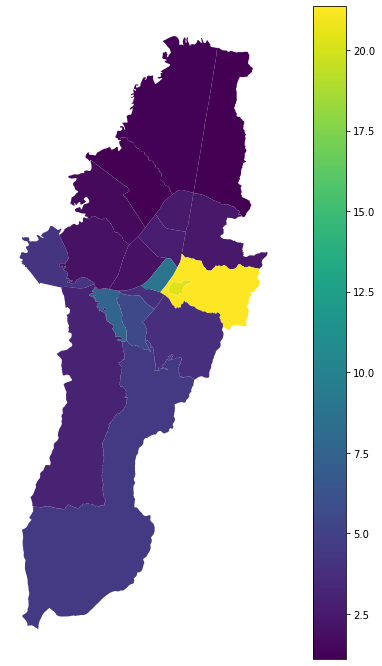

In [90]:
fig, ax = plt.subplots(figsize=(12,12))
map_localidad(ax,subdata,'NOMBRE_LOCALIDAD','Porcentaje')
ax.axis('off')
#ax.set_title(fecha)
plt.savefig("figuras_rnmc/riñas_rnmc_localidad_normalizada_probabilidad_mapa.png",dpi=300,bbox_inches = "tight")
plt.show()

### Análisis campo 'COD_UPZ' y 'UPZ'

Top values


COD_UPZ,NOMBRE_UPZ,Frecuencia
UPZ85,BOSA CENTRAL,12276
UPZ93,LAS NIEVES,9997
UPZ42,VENECIA,9691
UPZ84,BOSA OCCIDENTAL,8716
UPZ67,LUCERO,8176


Bottom values


COD_UPZ,NOMBRE_UPZ,Frecuencia
UPZ64,MONTE BLANCO,1
UPZ3,GUAYMARAL,8
UPZ2,LA ACADEMIA,20
UPZ60,PARQUE ENTRENUBES,37
UPZ89,SAN ISIDRO - PATIOS,52


Statistics


,Frecuencia
count,115.000000
mean,2009.686957
std,2252.952684
min,1.000000
25%,515.500000
50%,1227.000000
75%,2961.500000
max,12276.000000


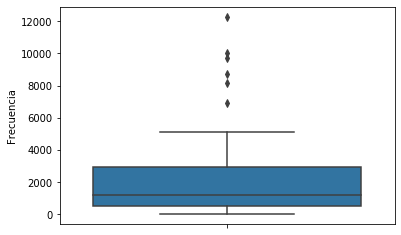

In [91]:
subdata = create_Subdata(data,["COD_UPZ","NOMBRE_UPZ"])
basic_Description(subdata)

In [92]:
bar_figure_top_values(subdata,variable='NOMBRE_UPZ',fig_name="riñas_rnmc_upz_frecuencias.png")

### Análisis campos 'COD_SCAT‘ y ‘NOMBRE_SECTOR_CAT'

Top values


COD_SCAT,NOMBRE_SECTOR_CAT,Frecuencia
2410,PARQUE EL TUNAL,2831
4529,CEMENTERIO JARDINES APOGEO,2809
3108,LA CAPUCHINA,2628
3101,LA ALAMEDA,2607
2404,VENECIA,2242


Bottom values


COD_SCAT,NOMBRE_SECTOR_CAT,Frecuencia
102309,EL BOSQUE SUR ORIENTAL RURAL II,1
102909,SAN BENITO,1
104130,BRAZUELOS OCCIDENTAL RURAL,1
201503,SIBERIA II,1
202203,BOLONIA I,1


Statistics


,COD_SCAT,Frecuencia
count,1061.000000,1061.000000
mean,17540.868049,217.826579
std,50582.795960,317.566734
min,1101.000000,1.000000
25%,2573.000000,42.000000
50%,5109.000000,117.000000
75%,8310.000000,258.000000
max,999999.000000,2831.000000


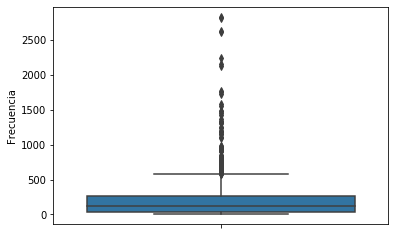

In [93]:
subdata = create_Subdata(data,["COD_SCAT","NOMBRE_SECTOR_CAT"])
basic_Description(subdata)

In [94]:
bar_figure_top_values(subdata,variable='NOMBRE_SECTOR_CAT',fig_name="riñas_rnmc_sec_catastral_frecuencias.png")

### Análisis campos 'COD_BARRIO' Y 'NOMBRE_BARRIO'

Top values


COD_BARRIO,NOMBRE_BARRIO,Frecuencia
1080,PARQUE EL TUNAL,2736
2501,LA ALAMEDA,2714
10,LA CAPUCHINA,2521
308,CEMENTERIO JARDINES APOGEO,2385
629,VENECIA,2229


Bottom values


COD_BARRIO,NOMBRE_BARRIO,Frecuencia
2226,S.C INTERINDUSTRIAL,1
2713,LA EMILIA,1
2708,TORREDON,1
2706,VILLA SANDRA,1
336,S.C. CAROLINA DE SUBA,1


Statistics


,COD_BARRIO,Frecuencia
count,3.320000e+03,3320.000000
mean,3.031067e+05,69.612651
std,1.735522e+07,182.401378
min,1.000000e+00,1.000000
25%,9.477500e+02,5.000000
50%,1.847500e+03,18.000000
75%,2.861250e+03,57.000000
max,1.000000e+09,2736.000000


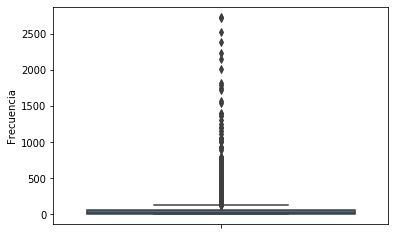

In [95]:
subdata = create_Subdata(data,["COD_BARRIO","NOMBRE_BARRIO"])
basic_Description(subdata)

In [96]:
bar_figure_top_values(subdata,variable='NOMBRE_BARRIO',fig_name="riñas_rnmc_barrio_frecuencias.png")

### Análisis campos (LATITUD, LONGITUD)

Top values


LATITUD,LONGITUD,Frecuencia
4.65251,-74.1133,648
4.59726,-74.1759,596
4.77083,-74.0427,130
4.63345,-74.1644,83
4.73257,-74.0885,73


Bottom values


LATITUD,LONGITUD,Frecuencia
4.3843,-74.138,1
4.62153,-74.1372,1
4.62153,-74.1976,1
4.62153,-74.1879,1
4.62153,-74.1942,1


Statistics


,LATITUD,LONGITUD,Frecuencia
count,217772.000000,217772.000000,217772.000000
mean,4.610649,-74.120884,1.061266
std,0.059978,0.041936,1.991951
min,4.384297,-74.220056,1.000000
25%,4.570279,-74.151321,1.000000
50%,4.603266,-74.115446,1.000000
75%,4.634820,-74.086998,1.000000
max,4.822879,-74.006582,648.000000


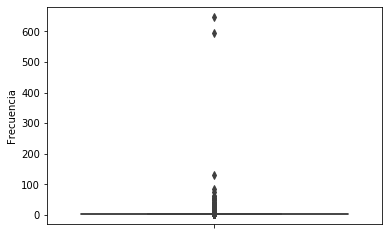

In [97]:
subdata = create_Subdata(data,["LATITUD","LONGITUD"])
basic_Description(subdata)

### Análisis campo 'TIPO_SITIO'

TIPO_SITIO,Frecuencia
DOMICILIO,910
MEDIO DE TRANSPORTE,2068
NO APLICA,244
SITIOS PUBLICOS O ABIERTOS AL PUBLICO,227892


Statistics


,Frecuencia
count,4.000000
mean,57778.500000
std,113411.503936
min,244.000000
25%,743.500000
50%,1489.000000
75%,58524.000000
max,227892.000000


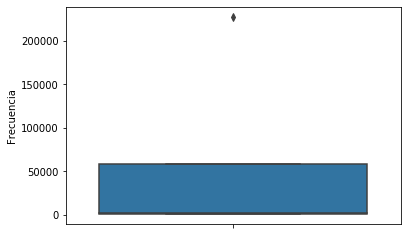

In [115]:
subdata = create_Subdata(data,["TIPO_SITIO"])
basic_Description(subdata)

In [116]:
bar_figure_top_values(subdata,variable='TIPO_SITIO',fig_name="riñas_rnmc_tipo_sitio_frecuencias.png")

### Análisis campo 'RANGO_EDAD_1'

Top values


RANGO_EDAD_1,Frecuencia
20 - 24 A?OS,76043
25 - 29 A?OS,49289
15 - 19 A?OS,31820
30 - 34 A?OS,29073
35 - 39 A?OS,19300


Bottom values


RANGO_EDAD_1,Frecuencia
100 - 104 A?OS,1
90 - 94 A?OS,2
5 - 9 A?OS,4
95 - 99 A?OS,6
0 - 4 A?OS,8


Statistics


,Frecuencia
count,21.000000
mean,11005.428571
std,20086.725909
min,1.000000
25%,14.000000
50%,555.000000
75%,10547.000000
max,76043.000000


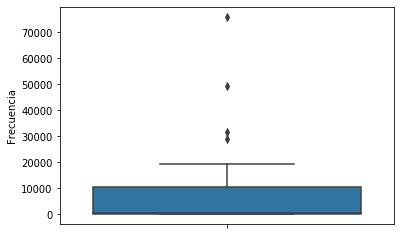

In [117]:
subdata = create_Subdata(data,["RANGO_EDAD_1"])
basic_Description(subdata)

In [119]:
bar_figure_top_values(subdata,variable='RANGO_EDAD_1',fig_name="riñas_rnmc_rango_edad_frecuencias.png")

### Análisis campo 'TITULO'

TITULO,Frecuencia
Titulo 3,231114


Statistics


,Frecuencia
count,1.0
mean,231114.0
std,NaN
min,231114.0
25%,231114.0
50%,231114.0
75%,231114.0
max,231114.0


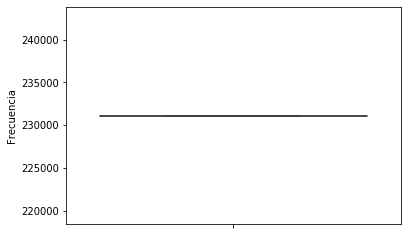

In [98]:
subdata = create_Subdata(data,["TITULO"])
basic_Description(subdata)

### Análisis campo 'CAPITULO'

CAPITULO,Frecuencia
Capitulo 1,231114


Statistics


,Frecuencia
count,1.0
mean,231114.0
std,NaN
min,231114.0
25%,231114.0
50%,231114.0
75%,231114.0
max,231114.0


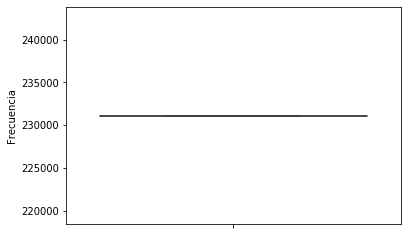

In [100]:
subdata = create_Subdata(data,["CAPITULO"])
basic_Description(subdata)

### Análisis campo 'ARTICULO'

ARTICULO,Frecuencia
27,231114


Statistics


,ARTICULO,Frecuencia
count,1.0,1.0
mean,27.0,231114.0
std,NaN,NaN
min,27.0,231114.0
25%,27.0,231114.0
50%,27.0,231114.0
75%,27.0,231114.0
max,27.0,231114.0


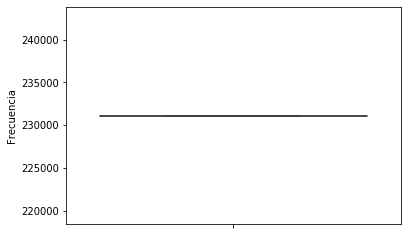

In [101]:
subdata = create_Subdata(data,["ARTICULO"])
basic_Description(subdata)

In [102]:
data['DESCRIPCION_ARTICULO'].unique()

array(['Comportamientos que ponen en riesgo la vida e integridad. Corregido por el art. 1, Decreto 555 de 2017. Los siguientes comportamientos ponen en riesgo la vida e integridad de las personas, y, por lo tanto, son contrarios a la convivencia:'],
      dtype=object)

### Análisis campo 'COD_COMPORTAMIENTO'

COD_COMPORTAMIENTO,DESCRIPCION_COMPORTAMIENTO,Frecuencia
Articulo 27,"Comportamientos que ponen en riesgo la vida e integridad. Corregido por el art. 1, Decreto 555 de 2017. Los siguientes comportamientos ponen en riesgo la vida e integridad de las personas, y, por lo tanto, son contrarios a la convivencia:",76
Numeral 1,"Re?ir, incitar o incurrir en confrontaciones violentas que puedan derivar en agresiones fisicas.",17603
Numeral 2,Lanzar objetos que puedan causar da?o o sustancias peligrosas a personas.,426
Numeral 3,Agredir fisicamente a personas por cualquier medio.,2854
Numeral 4,Amenazar con causar un da?o fisico a personas por cualquier medio.,1080
Numeral 5,"No retirar o reparar, en los inmuebles, los elementos que ofrezcan riesgo a la vida e integridad.",51
Numeral 6,"Portar armas, elementos cortantes, punzantes o semejantes, o sustancias peligrosas, en areas comunes o lugares abiertos al publico. Se exceptua a quien demuestre que tales elementos o sustancias constituyen una herramienta de su actividad deportiva, oficio, profesion o estudio.",206919
Numeral 7,"Portar armas neumaticas, de aire, de fogueo, de letalidad reducida o sprays, rociadores, aspersores o aerosoles de pimienta o cualquier elemento que se asimile a armas de fuego, en lugares abiertos al publico donde se desarrollen aglomeraciones de personas o en aquellos donde se consuman bebidas embriagantes, o se advierta su utilizacion irregular, o se incurra en un comportamiento contrario a la convivencia.",2105


Statistics


,Frecuencia
count,8.000000
mean,28889.250000
std,72172.967475
min,51.000000
25%,338.500000
50%,1592.500000
75%,6541.250000
max,206919.000000


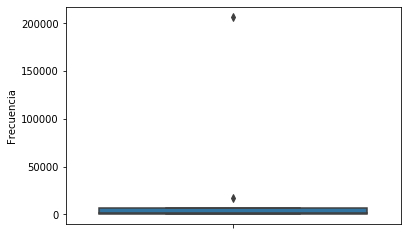

In [105]:
subdata = create_Subdata(data,["COD_COMPORTAMIENTO","DESCRIPCION_COMPORTAMIENTO"])
basic_Description(subdata)

In [104]:
bar_figure_top_values(subdata,variable='COD_COMPORTAMIENTO',fig_name="riñas_rnmc_cod_comportamiento_frecuencias.png")

### Análisis campo 'TIPO_PRIORIZACION'

TIPO_PRIORIZACION,Frecuencia
RI?AS,231114


Statistics


,Frecuencia
count,1.0
mean,231114.0
std,NaN
min,231114.0
25%,231114.0
50%,231114.0
75%,231114.0
max,231114.0


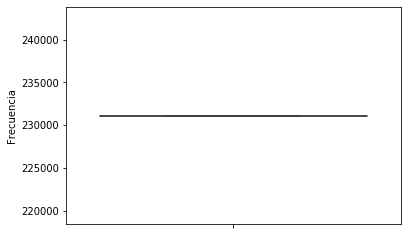

In [106]:
subdata = create_Subdata(data,["TIPO_PRIORIZACION"])
basic_Description(subdata)

### Análisis campo 'MEDIDA_CORRECTIVA_CODIGO'

MEDIDA_CORRECTIVA_CODIGO,Frecuencia
AMONESTACION; PARTICIPACION EN PROGRAMA COMUNITARIO O ACTIVIDAD PEDAGOGICA DE CONVIVENCIA;,427
"CONSTRUCCION, CERRAMIENTO, REPARACION; O MANTENIMIENTO DE INMUEBLES; REMOCION DE BIENES; REPARACION DE DA?OS MATERIALES DE MUEBLES; DESTRUCCION DE BIEN;",51
MULTA GENERAL TIPO 2;,17611
"MULTA GENERAL TIPO 2; PROHIBICION DE INGRESO A EVENTOS QUE INVOLUCREN AGLOMERACIONES DE PUBLICO COMPLEJAS O NO COMPLEJAS, DESTRUCCION DE BIEN;",209090
MULTA GENERAL TIPO 3;,2854
PARTICIPACION EN PROGRAMA COMUNITARIO O ACTIVIDAD PEDAGOGICA DE CONVIVENCIA; MULTA GENERAL TIPO 2;,1081


Statistics


,Frecuencia
count,6.00000
mean,38519.00000
std,83828.38906
min,51.00000
25%,590.50000
50%,1967.50000
75%,13921.75000
max,209090.00000


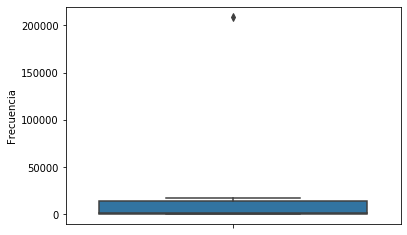

In [107]:
subdata = create_Subdata(data,["MEDIDA_CORRECTIVA_CODIGO"])
basic_Description(subdata)

In [108]:
bar_figure_top_values(subdata,variable='MEDIDA_CORRECTIVA_CODIGO',fig_name="riñas_rnmc_medida_correctiva_frecuencias.png")

### Análisis campo 'ES_PEDAGOGICO'

ES_PEDAGOGICO,Frecuencia
NO,223337
SI,7777


Statistics


,Frecuencia
count,2.000000
mean,115557.000000
std,152423.937753
min,7777.000000
25%,61667.000000
50%,115557.000000
75%,169447.000000
max,223337.000000


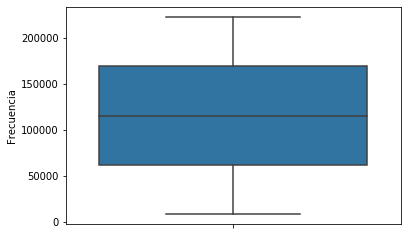

In [109]:
subdata = create_Subdata(data,["ES_PEDAGOGICO"])
basic_Description(subdata)

In [110]:
bar_figure_top_values(subdata,variable='ES_PEDAGOGICO',fig_name="riñas_rnmc_pedagogico_frecuencias.png")

### Análisis campo 'ACTIVIDAD_COMERCIAL'

Top values


ACTIVIDAD_COMERCIAL,Frecuencia
ND,230865
TRANSPORTE MASIVO,157
0,20
NO APLICA,15
VIA PUBLICA,13


Bottom values


ACTIVIDAD_COMERCIAL,Frecuencia
VENTA Y ARREGLO DE ELECTRODOMESTICOS,1
KSJDND,1
VIA OUBLICA,1
NINGUNA,1
VENTA DE FRUTAS Y LEGUMBRES,1


Statistics


,Frecuencia
count,45.000000
mean,5135.866667
std,34414.486588
min,1.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,230865.000000


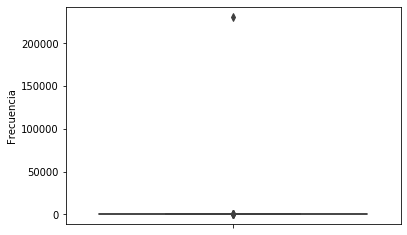

In [111]:
subdata = create_Subdata(data,["ACTIVIDAD_COMERCIAL"])
basic_Description(subdata)

In [112]:
bar_figure_top_values(subdata,variable='ACTIVIDAD_COMERCIAL',fig_name="riñas_rnmc_actividad_comercial_frecuencias.png")

### Análisis campo 'RAZON_SOCIAL'

Top values


RAZON_SOCIAL,Frecuencia
ND,230865
TRANSMILENIO,161
NO APLICA,31
VIA PUBLICA,15
NO APORTA,2


Bottom values


RAZON_SOCIAL,Frecuencia
0000JJD,1
IGLESIA UNIVERSAL,1
LOS RECUERDOS DE ELLA,1
MOTEL FENIX,1
MUEBLES Y COLCHONES SUE?O IMPERIAL,1


Statistics


,Frecuencia
count,45.000000
mean,5135.866667
std,34414.487134
min,1.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,230865.000000


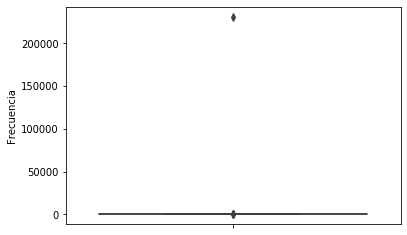

In [113]:
subdata = create_Subdata(data,["RAZON_SOCIAL"])
basic_Description(subdata)

In [114]:
bar_figure_top_values(subdata,variable='RAZON_SOCIAL',fig_name="riñas_rnmc_razon_social_frecuencias.png")

### Análisis campo 'STR_RELATO_HECHOS'

In [122]:
text = ' '.join(data['STR_RELATO_HECHOS'].str.lower())

stopwords = set(STOPWORDS)
stopwords.update(['de','la','el','que','y','con','en','se','le','al','su','un','una'])

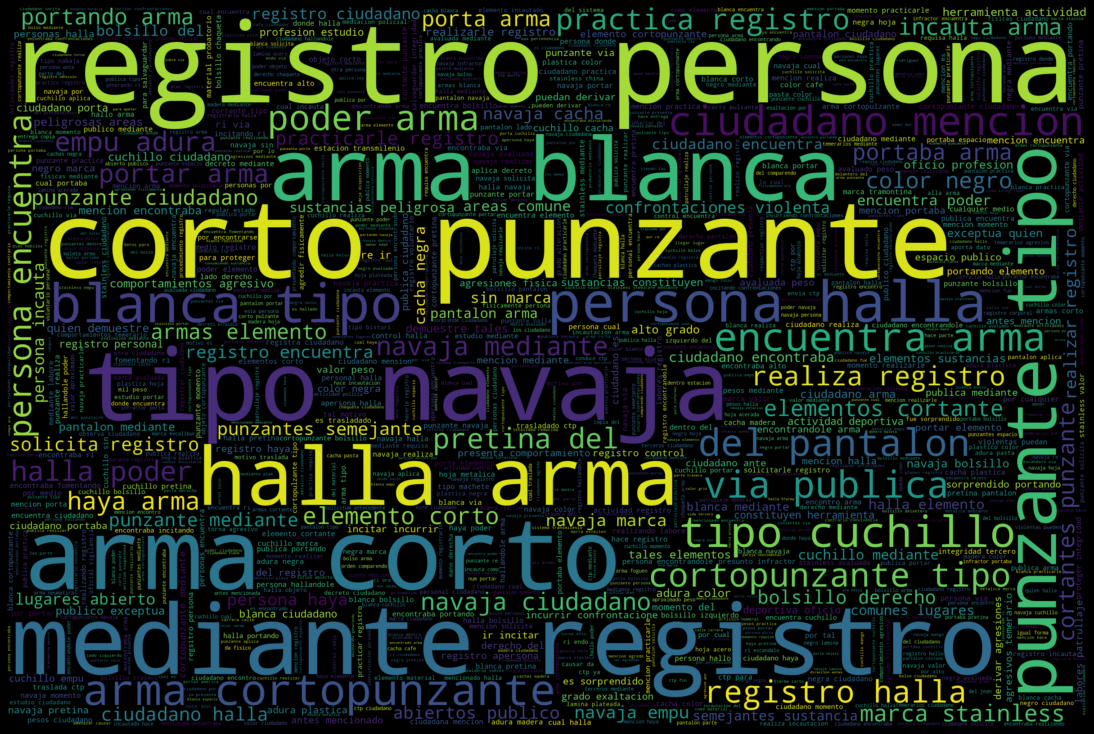

In [123]:
wordcloud = WordCloud(width = 3000,height = 2000,background_color = 'black',stopwords = stopwords, max_words=1000).generate(text)
fig = plt.figure(figsize = (20, 10),facecolor = 'k',edgecolor = 'k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.savefig("figuras_rnmc/relato_hechos",dpi=300,bbox_inches = "tight")
plt.show()

# ANÁLISIS BIVARIADO

## 'HORA' y día de la semana

In [ ]:
subdata=pd.DataFrame(data.groupby(["time_stamp","day_of_week"]).size(),columns=["Cantidad"]).sort_index().reset_index()

fig = px.line(subdata, x="time_stamp", y="Cantidad", facet_row="day_of_week", color="day_of_week",
              width=800, height=1400,  color_discrete_sequence = px.colors.qualitative.Prism[1:],
              category_orders={"day_of_week": ["Monday", "Tuesday", "Wednesday", "Thursday","Friday","Saturday","Sunday"]},
              labels={"day_of_week":"day"})
fig.update_layout(title_text="",
                 showlegend=False)
fig.write_image("figuras_nuse/riñas_nuse_dia_hora_ts.png")
fig.show()

## Rango hora y día de la semana

In [ ]:
subdata = create_Subdata(data,['RANGO_HORA','day_of_week'])

In [ ]:
#Probabilidad conjunta
var1='RANGO_HORA'
var2='day_of_week'
var1_order = ["0:00 a 3:59","4:00 a 7:59","8:00 a 11:59","12:00 a 15:59","16:00 a 19:59","20:00 a 23:59"]
var2_order = ["Monday", "Tuesday", "Wednesday", "Thursday","Friday","Saturday","Sunday"]
bubbles_figure_probabilities(subdata,var1,var2, var1_order,var2_order,fig_name="riñas_nuse_rango_hora_dia_conjunta.png")

In [ ]:
#Probabilidad condicional
var1='RANGO_HORA'
var2='day_of_week'
var_aux='STR_NUMERO_INTERNO'
var1_order = ["0:00 a 3:59","4:00 a 7:59","8:00 a 11:59","12:00 a 15:59","16:00 a 19:59","20:00 a 23:59"]
var2_order = ["Monday", "Tuesday", "Wednesday", "Thursday","Friday","Saturday","Sunday"]
table_figure_probabilities(data,var1,var2,var1_order,var2_order,var_aux,fig_name="riñas_nuse_rango_hora_dia_condicional_")

## Rango hora y día de la semana extendido

In [ ]:
subdata = create_Subdata(data,['RANGO_HORA','DIA_EXTENDIDO'])

In [ ]:
#Probabilidad conjunta
var1='RANGO_HORA'
var2='DIA_EXTENDIDO'
var1_order = ["0:00 a 3:59","4:00 a 7:59","8:00 a 11:59","12:00 a 15:59","16:00 a 19:59","20:00 a 23:59"]
var2_order = ["Monday", "Tuesday", "Wednesday", "Thursday","Friday","Saturday","Sunday"]
bubbles_figure_probabilities(subdata,var1,var2, var1_order,var2_order,fig_name="riñas_nuse_rango_hora_dia_extendido_conjunta.png")

In [ ]:
#Probabilidad condicional
var1='RANGO_HORA'
var2='DIA_EXTENDIDO'
var_aux='STR_NUMERO_INTERNO'
var1_order = ["4:00 a 7:59","8:00 a 11:59","12:00 a 15:59","16:00 a 19:59","20:00 a 23:59","0:00 a 3:59"]
var2_order = ["Monday", "Tuesday", "Wednesday", "Thursday","Friday","Saturday","Sunday"]
table_figure_probabilities(data,var1,var2,var1_order,var2_order,var_aux,fig_name="riñas_nuse_rango_hora_dia_extendido_condicional_")

## Mes y día de la semana

In [ ]:
subdata = create_Subdata(data,['MES','day_of_week'])

In [ ]:
#Probabilidad conjunta
var1='MES'
var2='day_of_week'
var1_order = []
var2_order = ["Monday", "Tuesday", "Wednesday", "Thursday","Friday","Saturday","Sunday"]
bubbles_figure_probabilities(subdata,var1,var2, var1_order,var2_order,fig_name="riñas_nuse_mes_dia_conjunta.png")

In [ ]:
#Probabilidad condicional
var1='MES'
var2='day_of_week'
var_aux='STR_NUMERO_INTERNO'
var1_order = []
var2_order = ["Monday", "Tuesday", "Wednesday", "Thursday","Friday","Saturday","Sunday"]
table_figure_probabilities(data,var1,var2,var1_order,var2_order,var_aux,fig_name="riñas_nuse_mes_dia_condicional_")

## Mes y día de la semana extendido

In [ ]:
subdata = create_Subdata(data,['MES','DIA_EXTENDIDO'])

In [ ]:
#Probabilidad conjunta
var1='MES'
var2='DIA_EXTENDIDO'
var1_order = []
var2_order = ["Monday", "Tuesday", "Wednesday", "Thursday","Friday","Saturday","Sunday"]
bubbles_figure_probabilities(subdata,var1,var2, var1_order,var2_order,fig_name="riñas_nuse_mes_dia_extendido_conjunta.png")

In [ ]:
#Probabilidad condicional
var1='MES'
var2='DIA_EXTENDIDO'
var_aux='STR_NUMERO_INTERNO'
var1_order = []
var2_order = ["Monday", "Tuesday", "Wednesday", "Thursday","Friday","Saturday","Sunday"]
table_figure_probabilities(data,var1,var2,var1_order,var2_order,var_aux,fig_name="riñas_nuse_mes_dia_extendido_condicional_")

## Mes y año

In [ ]:
subdata = create_Subdata(data2018,['MES','ANIO'])

In [ ]:
#Probabilidad conjunta
var1='MES'
var2='ANIO'
var1_order = []
var2_order = []
bubbles_figure_probabilities(subdata,var1,var2, var1_order,var2_order,fig_name="riñas_nuse_mes_año_conjunta.png")

In [ ]:
#Probabilidad condicional
var1='ANIO'
var2='MES'
var_aux='STR_NUMERO_INTERNO'
var1_order = []
var2_order = []
table_figure_probabilities(data2018,var1,var2,var1_order,var2_order,var_aux,fig_name="riñas_nuse_mes_año_condicional_")

## Localidades y rango hora

In [ ]:
subdata = create_Subdata(data,['LOCALIDAD','RANGO_HORA'])

In [ ]:
#Probabilidad conjunta
var1='LOCALIDAD'
var2='RANGO_HORA'
var1_order = []
var2_order = ["0:00 a 3:59","4:00 a 7:59","8:00 a 11:59","12:00 a 15:59","16:00 a 19:59","20:00 a 23:59"]
bubbles_figure_probabilities(subdata,var1,var2, var1_order,var2_order,fig_name="riñas_nuse_localidad_rango_hora_conjunta.png")

In [ ]:
#Probabilidad condicional
var1='LOCALIDAD'
var2='RANGO_HORA'
var_aux='STR_NUMERO_INTERNO'
var1_order = []
var2_order = ["0:00 a 3:59","4:00 a 7:59","8:00 a 11:59","12:00 a 15:59","16:00 a 19:59","20:00 a 23:59"]
table_figure_probabilities(data,var1,var2,var1_order,var2_order,var_aux,fig_name="riñas_nuse_localidad_rango_hora_condicional_")

## Localidades y día de la semana

In [ ]:
subdata = create_Subdata(data,['LOCALIDAD','day_of_week'])

In [ ]:
#Probabilidad conjunta
var1='LOCALIDAD'
var2='day_of_week'
var1_order = []
var2_order = ["Monday", "Tuesday", "Wednesday", "Thursday","Friday","Saturday","Sunday"]
bubbles_figure_probabilities(subdata,var1,var2, var1_order,var2_order,fig_name="riñas_nuse_localidad_dia_conjunta.png")

In [ ]:
#Probabilidad condicional
var1='LOCALIDAD'
var2='day_of_week'
var_aux='STR_NUMERO_INTERNO'
var1_order = []
var2_order = ["Monday", "Tuesday", "Wednesday", "Thursday","Friday","Saturday","Sunday"]
table_figure_probabilities(data,var1,var2,var1_order,var2_order,var_aux,fig_name="riñas_nuse_localidad_dia_condicional_")

## Localidades y día extendido

In [ ]:
subdata = create_Subdata(data,['LOCALIDAD','DIA_EXTENDIDO'])

In [ ]:
#Probabilidad conjunta
var1='LOCALIDAD'
var2='DIA_EXTENDIDO'
var1_order = []
var2_order = ["Monday", "Tuesday", "Wednesday", "Thursday","Friday","Saturday","Sunday"]
bubbles_figure_probabilities(subdata,var1,var2, var1_order,var2_order,fig_name="riñas_nuse_localidad_dia_extendido_conjunta.png")

In [ ]:
#Probabilidad condicional
var1='LOCALIDAD'
var2='DIA_EXTENDIDO'
var_aux='STR_NUMERO_INTERNO'
var1_order = []
var2_order = ["Monday", "Tuesday", "Wednesday", "Thursday","Friday","Saturday","Sunday"]
table_figure_probabilities(data,var1,var2,var1_order,var2_order,var_aux,fig_name="riñas_nuse_localidad_dia_extendido_condicional_")

## Localidades y mes

In [ ]:
subdata = create_Subdata(data,['LOCALIDAD','MES'])

In [ ]:
#Probabilidad conjunta
var1='LOCALIDAD'
var2='MES'
var1_order = []
var2_order = []
bubbles_figure_probabilities(subdata,var1,var2, var1_order,var2_order,fig_name="riñas_nuse_localidad_mes_conjunta.png")

In [ ]:
#Probabilidad condicional
var1='LOCALIDAD'
var2='MES'
var_aux='STR_NUMERO_INTERNO'
var1_order = []
var2_order = []
table_figure_probabilities(data,var1,var2,var1_order,var2_order,var_aux,fig_name="riñas_nuse_localidad_mes_condicional_")